# Empty drops

`pbmc_1k_v3`

In [1]:
import pandas as pd
import numpy as np
# import loompy as lp
import matplotlib.pyplot as plt
import scipy
# import scanpy as sc

## Data import

In [2]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
# dataset_meta = ['allen_'+x for x in ['B08']]
# dataset_names = [x for x in dataset_meta ]  
# raw_data_locations = [x for x in dataset_meta]
# transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

# loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
# n_datasets = len(loom_filepaths)


In [3]:
dataset_meta = 'pbmc_1k_v3'

In [4]:
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'

In [5]:
bcs_raw_loc_S = f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.barcodes.txt'
bcs_raw_loc_U = f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/unspliced.barcodes.txt'

In [6]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)
bcs_raw_S = pd.read_csv(bcs_raw_loc_S,header=None)
bcs_raw_U = pd.read_csv(bcs_raw_loc_U,header=None)

There's a shape mismatch. We need to merge the matrices into a common shape.

In [7]:
len(bcs_raw_S)

208549

In [8]:
len(bcs_raw_U)

179981

In [9]:
bcs_raw_U.isin(np.asarray(bcs_raw_S[0])).sum()

0    111231
dtype: int64

In [10]:
bcs_raw_S.isin(np.asarray(bcs_raw_U[0])).sum()

0    111231
dtype: int64

In [11]:
unique_bcs = list(np.unique(np.concatenate([bcs_raw_S,bcs_raw_U])))

In [12]:
len(unique_bcs)

277299

In [13]:
bcs = unique_bcs

In [14]:
assert unique_bcs == sorted(unique_bcs)
assert list(bcs_raw_S[0]) == sorted(bcs_raw_S[0])
assert list(bcs_raw_U[0]) == sorted(bcs_raw_U[0])


In [15]:
U_mtx_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/unspliced.mtx'
S_mtx_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.mtx'

In [16]:
S_raw = scipy.io.mmread(S_mtx_loc).T.astype(int)
U_raw = scipy.io.mmread(U_mtx_loc).T.astype(int)

In [17]:
U_ = scipy.sparse.coo_matrix((U_raw.shape[0],len(unique_bcs)),dtype=int)
S_ = scipy.sparse.coo_matrix((S_raw.shape[0],len(unique_bcs)),dtype=int)
assert U_.shape == S_.shape

In [18]:
qU = np.searchsorted(unique_bcs,bcs_raw_U[0]) 
qS = np.searchsorted(unique_bcs,bcs_raw_S[0])

In [19]:
U_.data = U_raw.data
U_.row = U_raw.row
U_.col = qU[U_raw.col]

S_.data = S_raw.data
S_.row = S_raw.row
S_.col = qS[S_raw.col]

In [20]:
U_raw = U_.tocsr()
S_raw = S_.tocsr()

In [21]:
thr_lb = 1e3

In [22]:
S_tot = np.squeeze(np.asarray(S_raw.sum(0)))
U_tot = np.squeeze(np.asarray(U_raw.sum(0)))

In [23]:
S_tot.shape

(277299,)

In [24]:
def knee_plot(umi_sum, ax1=None, thr=None, viz=False):
    n_cells = len(umi_sum)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells), usf, "k")
        ax1.set_xlabel("Cell rank")
        ax1.set_ylabel("UMI count+1")
        ax1.set_yscale("log")
    if thr is not None:
        cf = umi_sum > thr
        rank_ = np.argmin(np.abs(usf - thr))
        if viz:
            ax1.plot([0, n_cells + 1], thr * np.ones(2), "r--")
            ys = ax1.get_ylim()
            ax1.plot(rank_ * np.ones(2), ys, "r--")
        return cf


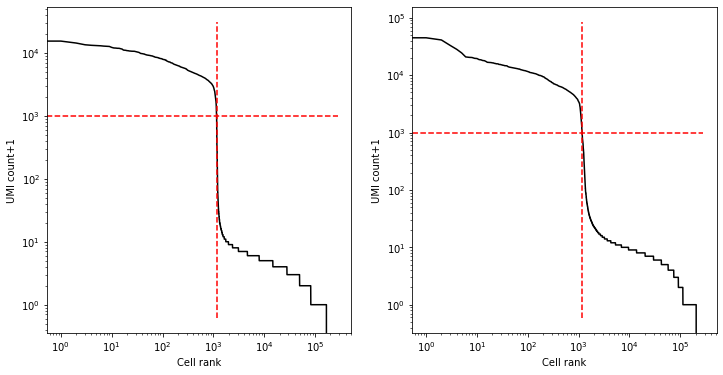

In [25]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot,ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot,ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

In [26]:
cf = np.isin(bcs,bcs_filtered)

In [27]:
len(cf)

277299

In [28]:
# cf = np.asarray(bcs_raw.isin(np.asarray(bcs_filtered).squeeze()),dtype=bool).squeeze()

In [29]:
cf.sum()

1200

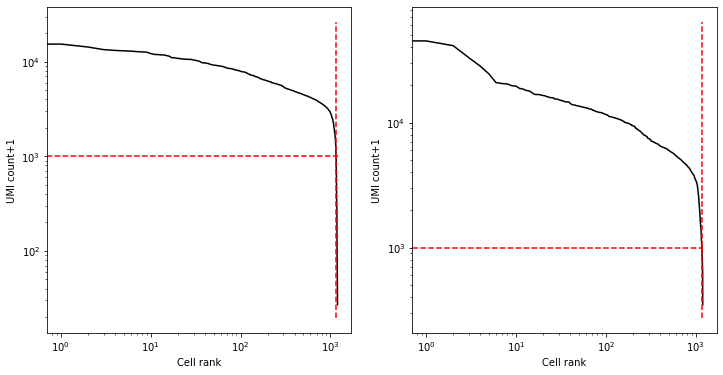

In [30]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[cf],ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

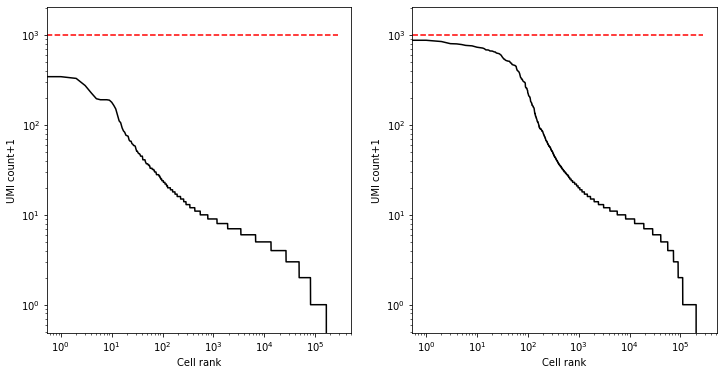

In [31]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[~cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[~cf],ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

In [33]:
# Smean.shape

In [34]:
Smean = np.asarray(S_raw.mean(1)).squeeze()
Umean = np.asarray(U_raw.mean(1)).squeeze()

In [35]:
Svar = np.asarray((S_raw.power(2)).mean(1)).squeeze()-Smean**2
Uvar = np.asarray((U_raw.power(2)).mean(1)).squeeze()-Umean**2

In [36]:
S_raw.shape

(36601, 277299)

In [38]:
# xl[0]

In [39]:
xl = [min(Smean),max(Smean)]

In [40]:
def plot_meanvar(X,cf_,ax):
    mean = np.asarray(X[:,cf_].mean(1)).squeeze()
    var = np.asarray((X[:,cf_].power(2)).mean(1)).squeeze()-mean**2
    ax.scatter(mean,var,3,'k',alpha=0.4)
    mean = mean[mean>0]
    xl = [min(mean),max(mean)]
    ax.plot(xl,xl,'r--')
    ax.set_xscale("log")
    ax.set_yscale("log")

In [41]:
def plot_corr(X,Y,cf_,ax):
    corrs = np.zeros(X.shape[0])
    corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[:,cf_],Y[:,cf_])])
    mean = np.asarray(X[:,cf_].mean(1)).squeeze()
    ax.scatter(mean,corrs,3,'k',alpha=0.4)
    ax.set_xscale("log")
    return corrs

In [42]:
def plot_mean_bg(X,cf_,ax):
#     corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
#     mean1 = np.squeeze((np.mean(X[:].toarray(),0)))
#     mean2 = np.squeeze((np.mean(X[~cf_,:].toarray(),0)))
    
    mean1 = np.asarray(X[:,cf_].mean(1)).squeeze()
    mean2 = np.asarray(X[:,~cf_].mean(1)).squeeze()
    
    lm1 = np.log10(mean1)
    lm2 = np.log10(mean2)
    gf = np.isfinite(lm1) & np.isfinite(lm2)
    
    lm1 = lm1[gf]
    lm2 = lm2[gf]
    
    ax.scatter(mean1,mean2,3,'k',alpha=0.4)
    xl = np.array([min(mean1),max(mean1)])
    ax.plot(xl,xl,'r--')        
    ax.plot(xl,xl*2.4e-4,'b--')        
    ax.set_xscale("log")
    ax.set_yscale("log")
    return np.corrcoef(lm1,lm2)[0][1]

In [43]:
U_raw.shape

(36601, 277299)

In [44]:
S_raw.shape

(36601, 277299)

/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


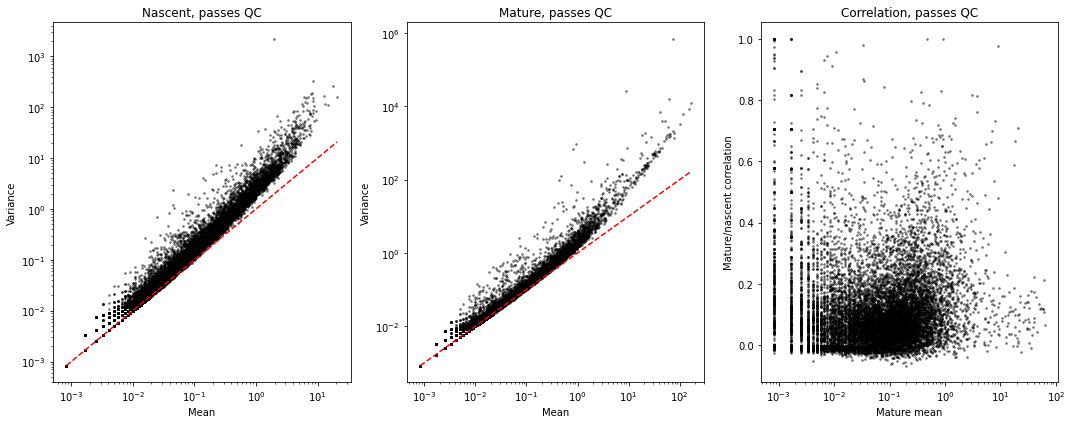

In [46]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))

plot_meanvar(U_raw,cf,ax1[0])
ax1[0].set_title("Nascent, passes QC")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(S_raw,cf,ax1[1])
ax1[1].set_title("Mature, passes QC")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_qc = plot_corr(S_raw,U_raw,cf,ax1[2])
ax1[2].set_title("Correlation, passes QC")
ax1[2].set_xlabel('Mature mean')
ax1[2].set_ylabel('Mature/nascent correlation')

fig1.tight_layout()

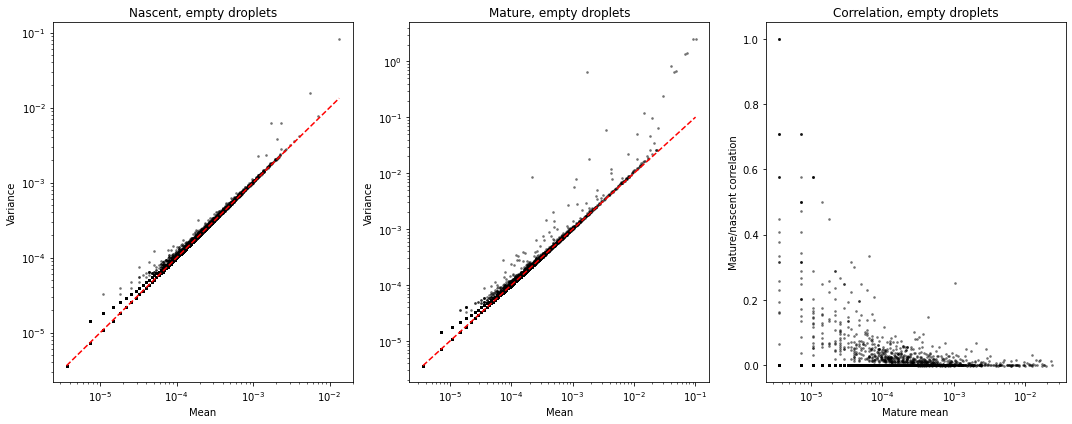

In [47]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))
plot_meanvar(U_raw,~cf,ax1[0])
ax1[0].set_title("Nascent, empty droplets")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(S_raw,~cf,ax1[1])
ax1[1].set_title("Mature, empty droplets")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_empty = plot_corr(S_raw,U_raw,~cf,ax1[2])
ax1[2].set_title("Correlation, empty droplets")
ax1[2].set_xlabel('Mature mean')
ax1[2].set_ylabel('Mature/nascent correlation')


fig1.tight_layout()

In [48]:
len(corrs_qc)

36601

In [49]:
len(corrs_empty)

36601

Text(0, 0.5, 'Density')

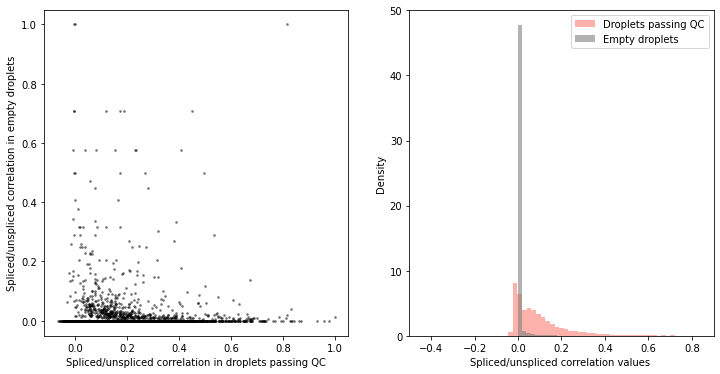

In [50]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
ax1[0].scatter(corrs_qc,corrs_empty,3,'k',alpha=0.4)
ax1[0].set_xlabel('Spliced/unspliced correlation in droplets passing QC')
ax1[0].set_ylabel('Spliced/unspliced correlation in empty droplets')

ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[1].legend()
ax1[1].set_xlim([-0.5,0.9])
ax1[1].set_xlabel('Spliced/unspliced correlation values ')
ax1[1].set_ylabel('Density')

/tmp/ipykernel_3119930/274176650.py:9: RuntimeWarning: divide by zero encountered in log10
  lm1 = np.log10(mean1)
/tmp/ipykernel_3119930/274176650.py:10: RuntimeWarning: divide by zero encountered in log10
  lm2 = np.log10(mean2)


Text(0, 0.5, 'Mean in empty droplets')

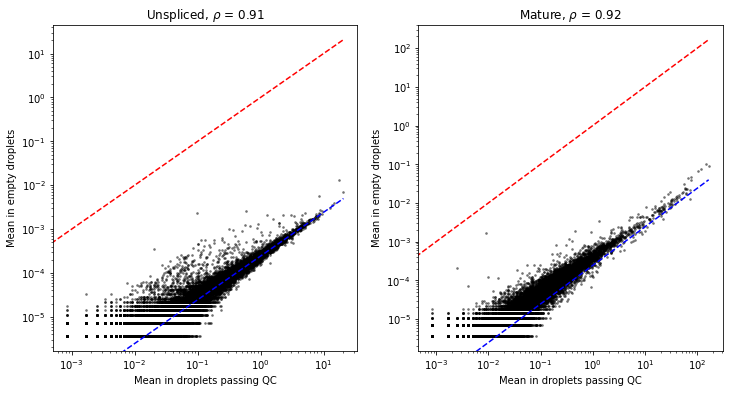

In [51]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
rho_U = plot_mean_bg(U_raw,cf,ax1[0])
ax1[0].set_title(r"Unspliced, $\rho$ = {:.2f}".format(rho_U))
ax1[0].set_xlabel('Mean in droplets passing QC')
ax1[0].set_ylabel('Mean in empty droplets')

rho_S = plot_mean_bg(S_raw,cf,ax1[1])
ax1[1].set_title(r"Mature, $\rho$ = {:.2f}".format(rho_S))
ax1[1].set_xlabel('Mean in droplets passing QC')
ax1[1].set_ylabel('Mean in empty droplets')

In [53]:
gf = np.asarray(S_raw.sum(1)>0,dtype=bool).squeeze()

In [56]:
genecorr_qc_S = np.corrcoef(S_raw[gf][:,cf].toarray())
genecorr_qc_S = genecorr_qc_S[np.triu_indices(len(genecorr_qc_S),1)]

In [59]:
genecorr_empty_S = np.corrcoef(S_raw[gf][:,~cf].toarray())
genecorr_empty_S = genecorr_empty_S[np.triu_indices(len(genecorr_empty_S),1)]

Text(0, 0.5, 'Density')

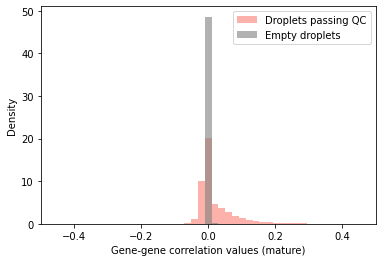

In [60]:
bins = np.linspace(-0.5,0.5,50)
plt.hist(genecorr_qc_S,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty_S,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (mature)')
plt.ylabel('Density')

In [61]:
gf = np.asarray(U_raw.sum(1)>0,dtype=bool).squeeze()

In [62]:
genecorr_qc_U = np.corrcoef(U_raw[gf][:,cf].toarray())
genecorr_qc_U = genecorr_qc_U[np.triu_indices(len(genecorr_qc_U),1)]

In [63]:
genecorr_empty_U = np.corrcoef(U_raw[gf][:,~cf].toarray())
genecorr_empty_U = genecorr_empty_U[np.triu_indices(len(genecorr_empty_U),1)]

In [76]:
import sys

These arrays are somewhat large. This means we have to compute them at runtime.

In [84]:
print('Size of nascent corr matrix (QC-passing): {:.2f} GB.'.format(sys.getsizeof(genecorr_qc_U)/(10**9)))
print('Size of mature corr matrix (QC-passing): {:.2f} GB.'.format(sys.getsizeof(genecorr_qc_S)/(10**9)))
print('Size of nascent corr matrix (empty): {:.2f} GB.'.format(sys.getsizeof(genecorr_empty_U)/(10**9)))
print('Size of mature corr matrix (empty): {:.2f} GB.'.format(sys.getsizeof(genecorr_empty_S)/(10**9)))

Size of nascent corr matrix (QC-passing): 1.67 GB.
Size of mature corr matrix (QC-passing): 1.24 GB.
Size of nascent corr matrix (empty): 1.67 GB.
Size of mature corr matrix (empty): 1.24 GB.


Text(0, 0.5, 'Density')

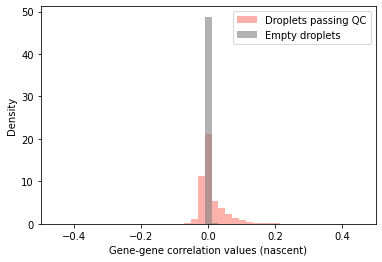

In [64]:
bins = np.linspace(-0.5,0.5,50)
plt.hist(genecorr_qc_U,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty_U,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (nascent)')
plt.ylabel('Density')

In [65]:
np.asarray(S_raw[:,~cf].sum(0)).squeeze().mean()

2.669176635916827

In [66]:
np.asarray(S_raw[:,~cf].sum(0)).squeeze().var()

115.90649221447612

In [67]:
np.asarray(S_raw[:,cf].sum(0)).squeeze().mean()

6296.7525

In [68]:
np.asarray(S_raw[:,cf].sum(0)).squeeze().var()

16441835.00624375

In [69]:
X =  S_raw

m1 = np.asarray(X[:,cf].mean(1)).squeeze()
v1 = np.asarray((X[:,cf].power(2)).mean(1)).squeeze()-m1**2
m2 = np.asarray(X[:,~cf].mean(1)).squeeze()
v2 = np.asarray((X[:,~cf].power(2)).mean(1)).squeeze()-m2**2


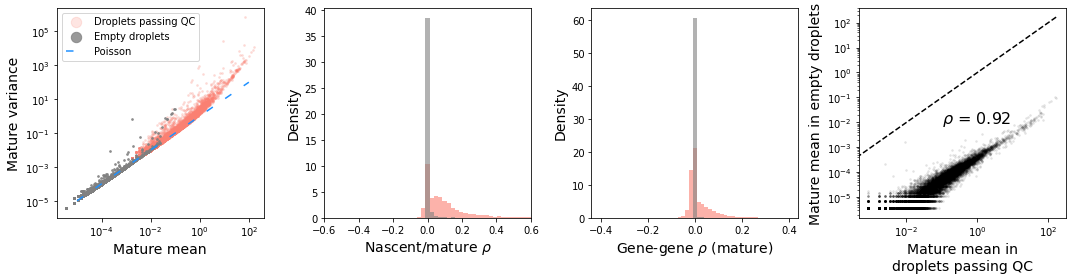

In [92]:

fs = 14
fig1,ax1 = plt.subplots(1,4,figsize=(15,4))

############
ax1[0].scatter(m1,v1,3,'salmon',alpha=0.2,label='Droplets passing QC')
ax1[0].scatter(m2,v2,3,'gray',alpha=0.8,label='Empty droplets')

xl = [1e-5,1e2]
ax1[0].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle=(0,(5,10)))        
ax1[0].set_xscale("log")
ax1[0].set_yscale("log")
ax1[0].set_xlabel('Mature mean',fontsize=fs)
ax1[0].set_ylabel('Mature variance',fontsize=fs)
ax1[0].legend(markerscale=6)

############
bins = np.linspace(-0.6,0.6,50)
ax1[1].hist(corrs_qc,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[1].legend()
ax1[1].set_xlim([-0.6,0.6])
ax1[1].set_xlabel(r'Nascent/mature $\rho$',fontsize=fs)
ax1[1].set_ylabel('Density',fontsize=fs)

#############

bins = np.linspace(-0.4,0.4,50)
ax1[2].hist(genecorr_qc_S,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[2].hist(genecorr_empty_S,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[2].legend(loc='upper left')
# ax1[2].set_xlim([-0.4,0.4])
ax1[2].set_xlabel(r'Gene-gene $\rho$ (mature)',fontsize=fs)
ax1[2].set_ylabel('Density',fontsize=fs)
    
#############
gf = (m1>0) & (m2>0)
lm1 = np.log10(m1[gf])
lm2 = np.log10(m2[gf])


ax1[3].scatter(m1,m2,3,'k',alpha=0.07)
xl = np.array([min(m1),max(m1)])
ax1[3].plot(xl,xl,'k--')        
ax1[3].set_xscale("log")
ax1[3].set_yscale("log")
ax1[3].text(0.4,0.45,r'$\rho$ = {:.2f}'.format(np.corrcoef(lm1,lm2)[0][1]),transform=ax1[3].transAxes,fontsize=fs+2)
ax1[3].set_xlabel('Mature mean in\ndroplets passing QC',fontsize=fs)
ax1[3].set_ylabel('Mature mean in empty droplets',fontsize=fs)


fig1.tight_layout()
# plt.subplots_adjust(right=1)
plt.savefig('figs/emptydrops.png',dpi=450)
plt.savefig('figs/emptydrops.pdf')
# plt.savefig('figs/emptydrops.svg')

In [510]:
print('Genes with nonzero mature mean and variance in droplets passing QC: {:,}'.format(((m1>0)&(v1>0)).sum()))
print('Genes with nonzero mature mean and variance in empty droplets: {:,}'.format(((m2>0)&(v2>0)).sum()))
print('Well-defined nascent/mature correlations in droplets passing QC: {:,}'.format(((~np.isnan(corrs_qc))).sum()))
print('Well-defined nascent/mature correlations in empty droplets: {:,}'.format(((~np.isnan(corrs_empty))).sum()))
print('Well-defined mature gene-gene correlations in droplets passing QC: {:,}'.format(((~np.isnan(genecorr_qc_S))).sum()))
print('Well-defined mature gene-gene correlations in empty droplets: {:,}'.format(((~np.isnan(genecorr_empty_S))).sum()))
print('Genes with nonzero mature mean in empty droplets and droplets passing QC: {:,}'.format(((m1>0)&(m2>0)).sum()))


Genes with nonzero mature mean and variance in droplets passing QC: 17,393
Genes with nonzero mature mean and variance in empty droplets: 12,298
Well-defined nascent/mature correlations in droplets passing QC: 14,365
Well-defined nascent/mature correlations in empty droplets: 9,362
Well-defined mature gene-gene correlations in droplets passing QC: 151,249,528
Well-defined mature gene-gene correlations in empty droplets: 75,614,253
Genes with nonzero mature mean in empty droplets and droplets passing QC: 12,107


In [494]:
X =  S_raw

m1S = np.asarray(X[:,cf].mean(1)).squeeze()
v1S = np.asarray((X[:,cf].power(2)).mean(1)).squeeze()-m1S**2
m2S = np.asarray(X[:,~cf].mean(1)).squeeze()
v2S = np.asarray((X[:,~cf].power(2)).mean(1)).squeeze()-m2S**2

X =  U_raw

m1U = np.asarray(X[:,cf].mean(1)).squeeze()
v1U = np.asarray((X[:,cf].power(2)).mean(1)).squeeze()-m1U**2
m2U = np.asarray(X[:,~cf].mean(1)).squeeze()
v2U = np.asarray((X[:,~cf].power(2)).mean(1)).squeeze()-m2U**2


In [495]:
corrs_qc.shape

(36601,)

Genes with nonzero nascent mean and variance in droplets passing QC: 20,283
Genes with nonzero mature mean and variance in droplets passing QC: 17,393
Genes with nonzero mature mean and well-defined N/M correlation in droplets passing QC: 14,365
Genes with nonzero nascent mean and variance in empty droplets: 14,563
Genes with nonzero mature mean and variance in empty droplets: 12,298
Genes with nonzero mature mean and well-defined N/M correlation in empty droplets: 9,362
Genes with well-defined N/M correlation in empty and QC-passing droplets: 9,279
Genes with well-defined N/M correlation in QC-passing droplets: 14,365
Genes with well-defined N/M correlations in empty droplets: 9,362
Well-defined nascent gene-gene correlations in droplets passing QC: 205,689,903
Well-defined nascent gene-gene correlations in empty droplets: 106,033,203
Well-defined mature gene-gene correlations in droplets passing QC: 151,249,528
Well-defined mature gene-gene correlations in empty droplets: 75,614,253


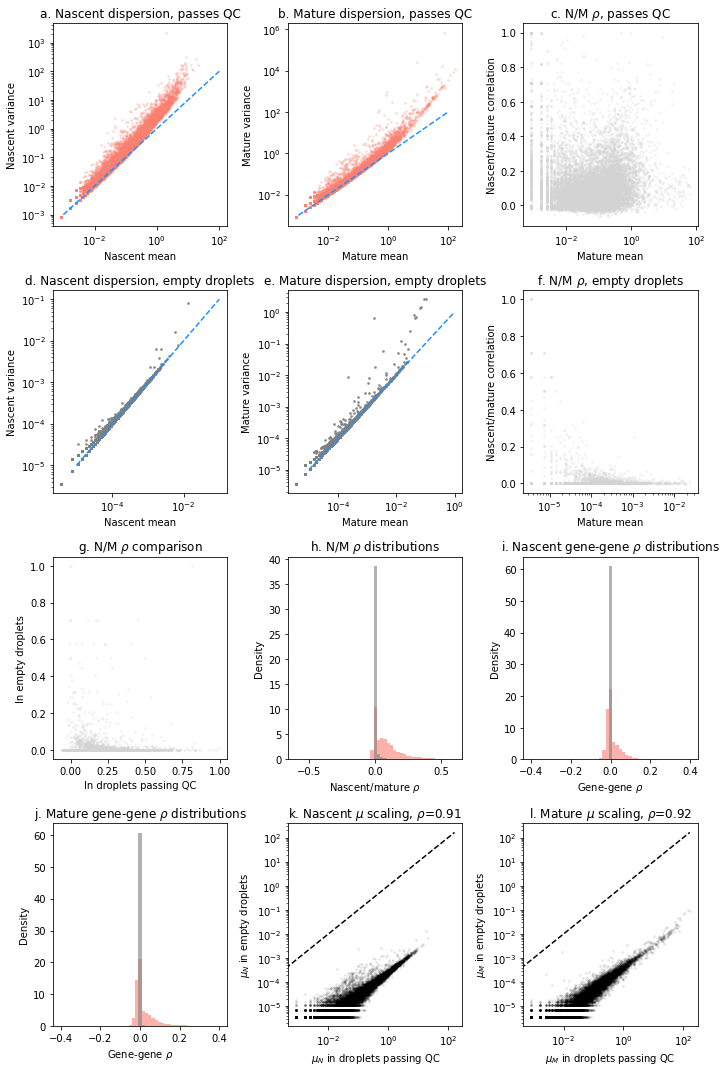

In [516]:

fs = 14
fig1,ax1 = plt.subplots(4,3,figsize=(10,15))

############
ax1[0,0].scatter(m1U,v1U,3,'salmon',alpha=0.2,label='Droplets passing QC')
xl = [1e-3,1e2]
ax1[0,0].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle='--')        
ax1[0,0].set_xscale("log")
ax1[0,0].set_yscale("log")
ax1[0,0].set_xlabel('Nascent mean')
ax1[0,0].set_ylabel('Nascent variance')
ax1[0,0].set_title('a. Nascent dispersion, passes QC')

print('Genes with nonzero nascent mean and variance in droplets passing QC: {:,}'.format(((m1U>0)&(v1U>0)).sum()))

############
ax1[0,1].scatter(m1S,v1S,3,'salmon',alpha=0.2,label='Droplets passing QC')
xl = [1e-3,1e2]
ax1[0,1].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle='--')        
ax1[0,1].set_xscale("log")
ax1[0,1].set_yscale("log")
ax1[0,1].set_xlabel('Mature mean')
ax1[0,1].set_ylabel('Mature variance')
ax1[0,1].set_title('b. Mature dispersion, passes QC')

print('Genes with nonzero mature mean and variance in droplets passing QC: {:,}'.format(((m1S>0)&(v1S>0)).sum()))

############
ax1[0,2].scatter(m1S,corrs_qc,3,'lightgray',alpha=0.2)
ax1[0,2].set_xscale("log")
ax1[0,2].set_xlabel('Mature mean')
ax1[0,2].set_ylabel('Nascent/mature correlation')
ax1[0,2].set_title(r'c. N/M $\rho$, passes QC')

print('Genes with nonzero mature mean and well-defined N/M correlation in droplets passing QC: {:,}'.format(((~np.isnan(corrs_qc))&(m1S>0)).sum()))


###########
############
ax1[1,0].scatter(m2U,v2U,3,'gray',alpha=0.8,label='Empty droplets')

xl = [1e-5,1e-1]
ax1[1,0].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle='--')        
ax1[1,0].set_xscale("log")
ax1[1,0].set_yscale("log")
ax1[1,0].set_xlabel('Nascent mean')
ax1[1,0].set_ylabel('Nascent variance')
ax1[1,0].set_title('d. Nascent dispersion, empty droplets')

print('Genes with nonzero nascent mean and variance in empty droplets: {:,}'.format(((m2U>0)&(v2U>0)).sum()))

############
ax1[1,1].scatter(m2S,v2S,3,'gray',alpha=0.8,label='Empty droplets')
xl = [1e-5,1e0]
ax1[1,1].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle='--')       
ax1[1,1].set_xscale("log")
ax1[1,1].set_yscale("log")
ax1[1,1].set_xlabel('Mature mean')
ax1[1,1].set_ylabel('Mature variance')
ax1[1,1].set_title('e. Mature dispersion, empty droplets')

print('Genes with nonzero mature mean and variance in empty droplets: {:,}'.format(((m2S>0)&(v2S>0)).sum()))

############
ax1[1,2].scatter(m2S,corrs_empty,3,'lightgray',alpha=0.2)
ax1[1,2].set_xscale("log")
ax1[1,2].set_xlabel('Mature mean')
ax1[1,2].set_ylabel('Nascent/mature correlation')
ax1[1,2].set_title(r'f. N/M $\rho$, empty droplets')

print('Genes with nonzero mature mean and well-defined N/M correlation in empty droplets: {:,}'.format(((~np.isnan(corrs_empty))&(m2S>0)).sum()))

############
############

ax1[2,0].scatter(corrs_qc,corrs_empty,3,'lightgray',alpha=0.2)
ax1[2,0].set_xlabel('In droplets passing QC')
ax1[2,0].set_ylabel('In empty droplets')
ax1[2,0].set_title(r'g. N/M $\rho$ comparison')

print('Genes with well-defined N/M correlation in empty and QC-passing droplets: {:,}'.format(((~np.isnan(corrs_empty))&(~np.isnan(corrs_qc))).sum()))


# ############

bins = np.linspace(-0.6,0.6,50)
ax1[2,1].hist(corrs_qc,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[2,1].hist(corrs_empty,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[2,1].set_xlabel(r'Nascent/mature $\rho$',)
ax1[2,1].set_ylabel('Density',)
ax1[2,1].set_title(r'h. N/M $\rho$ distributions')

print('Genes with well-defined N/M correlation in QC-passing droplets: {:,}'.format(((~np.isnan(corrs_qc))).sum()))
print('Genes with well-defined N/M correlations in empty droplets: {:,}'.format(((~np.isnan(corrs_empty))).sum()))


# #############

bins = np.linspace(-0.4,0.4,50)
ax1[2,2].hist(genecorr_qc_U,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[2,2].hist(genecorr_empty_U,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[2,2].set_xlabel(r'Gene-gene $\rho$',)
ax1[2,2].set_ylabel('Density',)
ax1[2,2].set_title(r'i. Nascent gene-gene $\rho$ distributions')
    
print('Well-defined nascent gene-gene correlations in droplets passing QC: {:,}'.format(((~np.isnan(genecorr_qc_U))).sum()))
print('Well-defined nascent gene-gene correlations in empty droplets: {:,}'.format(((~np.isnan(genecorr_empty_U))).sum()))

    
#############
#############

bins = np.linspace(-0.4,0.4,50)
ax1[3,0].hist(genecorr_qc_S,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[3,0].hist(genecorr_empty_S,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[3,0].set_xlabel(r'Gene-gene $\rho$',)
ax1[3,0].set_ylabel('Density',)
ax1[3,0].set_title(r'j. Mature gene-gene $\rho$ distributions')

print('Well-defined mature gene-gene correlations in droplets passing QC: {:,}'.format(((~np.isnan(genecorr_qc_S))).sum()))
print('Well-defined mature gene-gene correlations in empty droplets: {:,}'.format(((~np.isnan(genecorr_empty_S))).sum()))

#############

gf = (m1U>0) & (m2U>0)
lm1 = np.log10(m1U[gf])
lm2 = np.log10(m2U[gf])

ax1[3,1].scatter(m1U,m2U,3,'k',alpha=0.07)
xl = np.array([min(m1),max(m1)])
ax1[3,1].plot(xl,xl,'k--')        
ax1[3,1].set_xscale("log")
ax1[3,1].set_yscale("log")
ax1[3,1].set_xlabel(r'$\mu_N$ in droplets passing QC',)
ax1[3,1].set_ylabel(r'$\mu_N$ in empty droplets',)
ax1[3,1].set_title(r'k. Nascent $\mu$ scaling, $\rho$={:.2f}'.format(np.corrcoef(lm1,lm2)[0][1]))

print('Genes with nonzero nascent mean in empty droplets and droplets passing QC: {:,}'.format(gf.sum()))

#############

gf = (m1S>0) & (m2S>0)
lm1 = np.log10(m1S[gf])
lm2 = np.log10(m2S[gf])

ax1[3,2].scatter(m1S,m2S,3,'k',alpha=0.07)
xl = np.array([min(m1),max(m1)])
ax1[3,2].plot(xl,xl,'k--')        
ax1[3,2].set_xscale("log")
ax1[3,2].set_yscale("log")
ax1[3,2].set_xlabel(r'$\mu_M$ in droplets passing QC',)
ax1[3,2].set_ylabel(r'$\mu_M$ in empty droplets')
ax1[3,2].set_title(r'l. Mature $\mu$ scaling, $\rho$={:.2f}'.format(np.corrcoef(lm1,lm2)[0][1]))

print('Genes with nonzero mature mean in empty droplets and droplets passing QC: {:,}'.format(gf.sum()))


fig1.tight_layout()
# plt.subplots_adjust(right=1.05)
plt.savefig('figs/emptydrops_supp_pbmc_1k_v3.png',dpi=450)
plt.savefig('figs/emptydrops_supp_pbmc_1k_v3.pdf')
# plt.savefig('figs/emptydrops_supp_pbmc_1k_v3.svg')

In [521]:
cellsize_S_qc = np.asarray(S_raw[:,cf].sum(0)).squeeze()
cellsize_S_empty = np.asarray(S_raw[:,~cf].sum(0)).squeeze()


In [531]:
print('Total UMI count mean in droplets passing QC: {:.0f}'.format(cellsize_S_qc.mean()))
print('Total UMI count variance in droplets passing QC: {:.0f}'.format(cellsize_S_qc.var()))
print('Total UMI count mean in empty droplets: {:.2f}'.format(cellsize_S_empty.mean()))
print('Total UMI count variance in empty droplets: {:.2f}'.format(cellsize_S_empty.var()))


Total UMI count mean in droplets passing QC: 6297
Total UMI count variance in droplets passing QC: 16441835
Total UMI count mean in empty droplets: 2.67
Total UMI count variance in empty droplets: 115.91


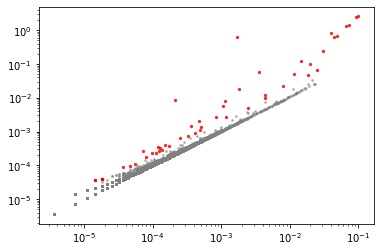

In [544]:
gf_overdisp = v2S>2*m2S
plt.scatter(m2S[gf_overdisp],v2S[gf_overdisp],5,'r',alpha=0.8)
plt.scatter(m2S[~gf_overdisp],v2S[~gf_overdisp],3,'gray',alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [545]:
cellsize_S_empty_filt = np.asarray(S_raw[~gf_overdisp][:,~cf].sum(0)).squeeze()
print('Total UMI count mean in empty droplets (excluding overdispersed genes): {:.2f}'.format(cellsize_S_empty_filt.mean()))
print('Total UMI count variance in empty droplets (excluding overdispersed genes): {:.2f}'.format(cellsize_S_empty_filt.var()))

Total UMI count mean in empty droplets (excluding overdispersed genes): 2.05
Total UMI count variance in empty droplets (excluding overdispersed genes): 15.51


In [547]:
gene_ref_loc = '/home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto-D/ref.t2g'
gene_ref = pd.read_csv(gene_ref_loc,header=None,sep='\t')
gene_ref = gene_ref.iloc[:,1:3]
gene_ref.columns = ['gene_id','gene_name']
gene_ref.set_index('gene_id',inplace=True)


In [550]:
gene_names = pd.read_csv(f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.genes.txt',header=None,sep='\t')


In [552]:
len(gf_overdisp)

36601

In [581]:
overdisp_genes = gene_ref.loc[list(gene_names[gf_overdisp][0])]['gene_name'].unique()

In [583]:
for x in overdisp_genes:
    print(x)

SH3BGRL3
PDZK1IP1
TAGLN2
S100A13
RGS18
NRGN
XRRA1
HBB
HBG2
MTRNR2L8
ACRBP
CMTM5
HBA2
C16orf95
HBA1
ITGA2B
MTRNR2L1
IL1RN
CAVIN2
TUBB1
MAP3K7CL
GP1BB
IGLC2
IGLC3
CLDN5
GP9
MTRNR2L12
PPBP
PF4
SPARC
F2R
FAXDC2
DHFR
TMEM161B-AS1
HIST1H2AC
MPIG6B
GNG11
ACTB
FAM83A
SDC2
CLU
MT-ND3
MT-ND4
MT-ND1
MT-ND2
MT-ND5
MT-CO1
MT-ND6
MT-CO2
MT-CYB
MT-ATP6
MT-CO3
TMSB4X


## Illustrations

In [4]:
x_ = np.arange(7)
poiss1 = scipy.stats.poisson(0.5)
poiss2 = scipy.stats.poisson(0.3)
y1 = poiss1.pmf(x_)
y2 = poiss2.pmf(x_)
fs = 14

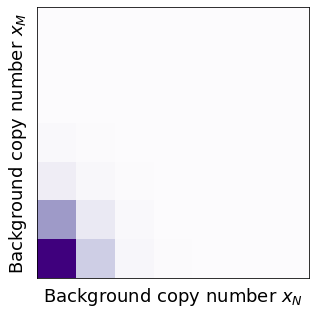

In [5]:

Y = np.outer(y1,y2)
plt.figure(figsize=(5,5))
ax = plt.gca()
plt.imshow((Y),cmap='Purples')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Background copy number $x_N$',fontsize=fs+4)
plt.ylabel(r'Background copy number $x_M$',fontsize=fs+4)
# ax.text(1,0.7,r'$P(x_N,x_M)=P(x_N;cp_N\mu_N)\times P(x_M;cp_M\mu_M)$',transform=ax.transAxes,fontsize=fs,horizontalalignment='right')

plt.savefig('figs/poissprod.png',dpi=450,transparent=True)
# plt.savefig('figs/poissprod.svg')
plt.savefig('figs/poissprod.pdf')